## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 2: From ML To FL

### R. Gafur, A. Jung

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 17.03.2025</h2>
</div>
    
<a id='varying_features'></a><div class="alert alert-info">
## Learning Goals:

- Implement a federated learning (FL) network using the Python package `networkx`. 
- Analyze FL network via node degrees and Laplacian matrix.
- Use data-driven constructions ("graph learning") for a FL network. 
- Implement a simple FL algorithm (local averaging) for a FL network. 

## Backround Material

- Chapter 3,7 of [FLBook (PDF)](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)
- optional: [networkx](TBD)
</div>

## Importing necessary libraries

In [2]:
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.0 MB/s eta 0:00:00a 0:00:01


In [3]:

import networkx as nx  # NetworkX: Used for creating and analyzing graphs and networks

import numpy as np  # NumPy: Provides support for large, multi-dimensional arrays and mathematical operations

import pandas as pd  # Pandas: Used for data manipulation and analysis, especially with tabular data

import matplotlib.pyplot as plt  # Matplotlib: A plotting library for visualizing data

from scipy.spatial import distance_matrix  # SciPy's spatial module: Computes pairwise distance matrices between points

from scipy.linalg import eigh  # SciPy's linear algebra module: Computes eigenvalues and eigenvectors of symmetric matrices

## Generate FL Network with Random Data

<a id='generate_fl_network'></a>
<div class="alert alert-warning">

### 📌 TASK 2.1: Building a FL Network

In this task you have to implement a function `generate_FL_network(n_stations)` that creates a federated learning (FL) 
network with a given number of nodes.

The network should be characterized using a dataframe `station_data` containing metadata for the
entire network. In particulat, the dataframe contains, for each node,
  - Latitude (`latitude`) between 60 and 65 (randomly generated)
  - Longitude (`longitude`) between 24 and 30 (randomly generated)
  - Temperature statistics: `temperature_mean` between -10 and 20, and `temperature_std` between 1 and 5 (randomly generated)

The network itself is stored as a `networkx.Graph()` with nodes having attributes
  - `lat` which stores the latitude
  - `lon` which stores the longitutde
 - `dataset` which stored a local dataset of 100 simulated temperature values drawn from a Gaussian distribution with the node's `temperature_mean` and `temperature_std` and add `latitude`, `longitude`, and a simulated dataset of 100 temperature values into each node

The function shall return the generated graph (`G`) and the network metadata (`station_data`)

</div>


In [4]:
def generate_FL_network(n_stations):
    """
    Generates a federated learning (FL) network with `n_stations` nodes, 
    where each node represents an FMI station with a local dataset.
    """
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate random metadata for each station (latitude, longitude, temperature stats)
    station_data = pd.DataFrame({
        "latitude": np.random.uniform(60, 65, n_stations),
        "longitude": np.random.uniform(24, 30, n_stations),
        "temperature_mean": np.random.uniform(-10, 20, n_stations),
        "temperature_std": np.random.uniform(1, 5, n_stations)
    })

    # Initialize an empty graph
    G = nx.Graph()
    
    # Add nodes to the graph, each carrying a local dataset
    for idx, row in station_data.iterrows():
        
        ### TASK HINTS ###
        # local_dataset = Simulate a dataset of 100 temperature values with Gaussian distribution
        # G.add_node(...) Each node contains latitude, longitude, and a simulated dataset of 100 temperature values
        
        # YOUR CODE HERE
        
        # Simulate a dataset of 100 temperature values with Gaussian distribution
        local_dataset = np.random.normal(loc=row['temperature_mean'], 
                                         scale=row['temperature_std'], 
                                         size=100)
        
        # Add a node with attributes: latitude, longitude, temperature_mean, temperature_std, and dataset
        G.add_node(idx, 
                   lat=row['latitude'], 
                   lon=row['longitude'], 
                   temperature_mean=row['temperature_mean'], 
                   temperature_std=row['temperature_std'], 
                   dataset=local_dataset)

    return G, station_data

n_stations = 10
G_geo, geo_station_data = generate_FL_network(n_stations)
G_stat, stat_station_data = generate_FL_network(n_stations)

In [5]:
# Sanity checks

# Test that the graph has the correct number of nodes
assert len(G_geo.nodes) == 10, "Number of nodes in the FL network is incorrect"
assert len(G_stat.nodes) == 10, "Number of nodes in the FL network is incorrect"

print('Sanity check passed!')


Sanity check passed!


<a id='construct_edges'></a>
<div class="alert alert-warning">

### 📌 TASK 2.2: Construct Edges in the FL Network

Your goal is to implement a function `construct_edges(G, station_data, method)` that constructs edges in the **Federated Learning (FL) network graph** based on different distance metrics. This function will **add edges** to a given FL network graph (`G`), passed as input parameter. 

### **Parameters**
- **`G`** (`networkx.Graph`): An **undirected graph** representing the FL network. The function should **modify** `G` by adding edges.
  
- **`station_data`** (`pd.DataFrame`): A **DataFrame** containing node attributes, including geographical and statistical features.

- **`method`** (`str`): A string that indicates how to compute distances between nodes. Supported values:
  - **`'geo'`**: Uses **latitude** and **longitude** to compute geographical distances.
  - **`'stat'`**: Uses **temperature_mean** and **temperature_std** to compute statistical distances.

### **Behavior**
For each node in the network:
1. **Determine its five nearest neighbors** based on distance computations.
2. **Compute the pairwise distance matrix** using `distance_matrix(coords, coords)`, where `coords` is derived as follows:
   - **If `method='geo'`**: `coords` consists of **latitude** and **longitude** as a length-2 vector.
   - **If `method='stat'`**: `coords` consists of **temperature_mean** and **temperature_std** as a length-2 vector.
3. **Add edges** to the **five nearest neighbors** of each node.

### **Notes**
- This function **modifies the input graph `G` in place**; no new graph is created or returned.
- The distance matrix is computed using `distance_matrix(coords, coords)`, ensuring efficient pairwise distance calculations.
</div>

In [6]:
def construct_edges(G, station_data, method):
    """
    Constructs edges in the graph by connecting each node to its 5 nearest neighbors.
    Two methods are supported:
    - 'geo': Uses latitude and longitude to compute distances.
    - 'stat': Uses temperature mean and standard deviation to compute distances.
    """
    
    n = len(G.nodes)

    # Initialize coords as a NumPy array with the correct shape
    coords = np.zeros((n, 2))  # Two features per node
    
    # Select the representation vector based on the chosen method
    if method == 'geo':
        # Use geographical coordinates (latitude, longitude)
        coords[:, 0] = station_data['latitude'].values
        coords[:, 1] = station_data['longitude'].values
    elif method == 'stat':
        # Use statistical temperature features (temperature_mean, temperature_std)
        coords[:, 0] = station_data['temperature_mean'].values
        coords[:, 1] = station_data['temperature_std'].values

    # Compute pairwise distances between all nodes
    dist_matrix = distance_matrix(coords, coords)

    for i in range(n):
        ### TASK ###
        # Exclude the node itself and take the 5 closest nodes and add an edge with distance as weight
        # nearest_neighbors = 
        # for j in nearest_neighbors:
            # G.add_edge(...)
        
        
        # Exclude the node itself (set distance to a large number or NaN)
        dist_matrix[i, i] = np.inf
        
        # Find the indices of the 5 nearest neighbors (excluding itself)
        nearest_neighbors = np.argsort(dist_matrix[i])[:5]
        
        # Add an edge between node `i` and its 5 nearest neighbors
        for j in nearest_neighbors:
            distance = dist_matrix[i, j]
            # Add an edge with distance as weight
            G.add_edge(i, j, weight=distance)

    return G

G_geo = construct_edges(G_geo, geo_station_data, method='geo')
G_stat = construct_edges(G_stat, stat_station_data, method='stat')

In [7]:
# Sanity checks

# Each node should have minimum 5 neighbors
for i in G_geo.nodes():
    assert len(list(G_geo.neighbors(i))) >= 5, f"Node {i} does not have 5 neighbors"

print('Sanity check passed!')


Sanity check passed!


<a id='network_visualization'></a>
<div class="alert alert-info">

### Visualizing the FL Network with edges

Since we have generated the edges, now we can visualize the two networks — **Geo Network** and **Stat Network** — with a unified layout for easy comparison:

- **Node Relabeling**:  
  Both networks are updated so that node labels start from 1 instead of 0. This adjustment makes the node indexing more intuitive.

- **Common Position Dictionary**:  
  A position mapping is defined using geographical coordinates (longitude and latitude) from the station data. This ensures that the same node (e.g., node 1, node 2, etc.) appears at identical positions in both visualizations.

- **Plotting Setup**:  
  A single figure with two side-by-side subplots is created.  
  - The **Geo Network** is drawn on the left subplot using the edges of **G_geo**  
  - The **Stat Network** is drawn on the right subplot using the edged of **G_stat**  

</div>

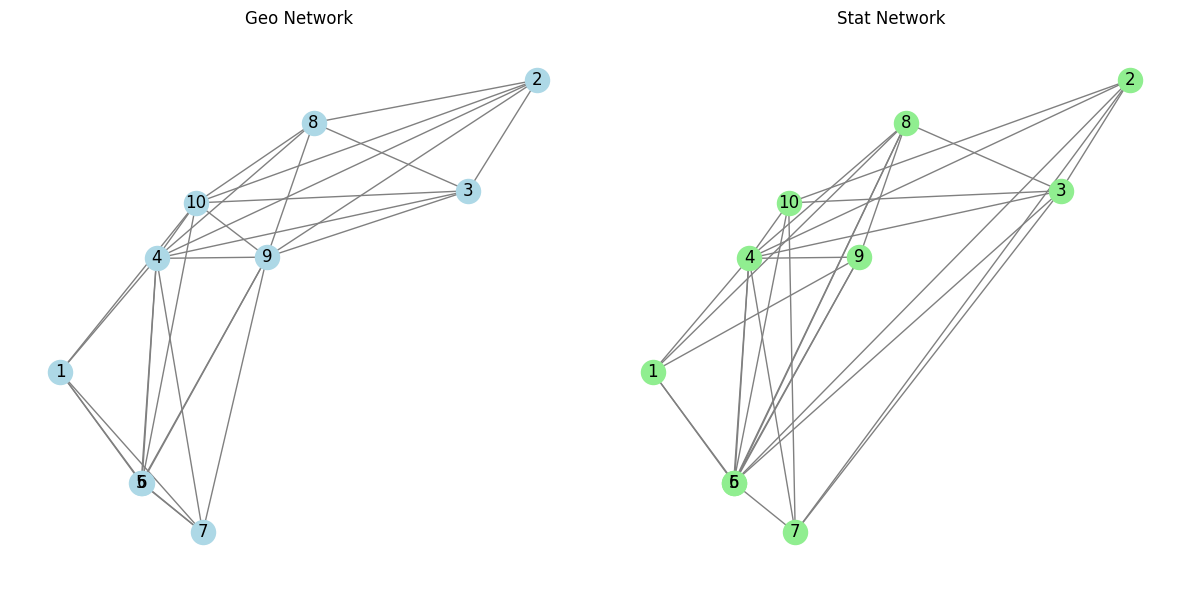

In [8]:
# Relabel nodes for both networks so that they start from 1 instead of 0
G_geo_relabel = nx.relabel_nodes(G_geo, {i: i+1 for i in G_geo.nodes()})
G_stat_relabel = nx.relabel_nodes(G_stat, {i: i+1 for i in G_stat.nodes()})

# Define a common position dictionary based on geo coordinates
# This ensures that node 1, node 2, etc. appear at the same locations in both visualizations
common_pos = {i+1: (geo_station_data.loc[i, "longitude"], geo_station_data.loc[i, "latitude"]) 
              for i in range(len(geo_station_data))}

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Geo network using the common layout
nx.draw(G_geo_relabel, pos=common_pos, ax=ax1, with_labels=True, node_color='lightblue', edge_color='gray')
ax1.set_title("Geo Network")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Plot Stat network using the same common layout
nx.draw(G_stat_relabel, pos=common_pos, ax=ax2, with_labels=True, node_color='lightgreen', edge_color='gray')
ax2.set_title("Stat Network")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

<a id='construct_edges'></a>
<div class="alert alert-warning">
    
### **📌 TASK 2.3: Analyze Federated Learning (FL) Network Connectivity**

Your task is to implement the function **`analyze_network(G)`** to analyze the connectivity of a given **Federated Learning (FL) network graph** `G`. This function will provide insights into the network structure by computing and visualizing key connectivity properties.

---

#### Compute and Plot Node Degrees
- Calculate the **degree** of each node (i.e., the number of connections).  
- Create a **bar plot** displaying the node degrees.  

#### Compute the Laplacian Matrix
- Compute the **Laplacian matrix** `L` of the graph.
- Convert `L` to an array format using `.toarray()` if necessary.

#### Analyze Eigenvalues and Eigenvectors
- Compute the **eigenvalues** and **eigenvectors** of `L`.
- Identify the **second smallest eigenvalue** (also known as the **algebraic connectivity**) and a corresponding eigenvector (**Fiedler vector**).
- Plot this **eigenvector** to visualize network connectivity.

---

### Hints
- The **Laplacian matrix** can be obtained using `nx.laplacian_matrix(G)`.  
- Convert the matrix to an array using `.toarray()` if needed.  
- The **second smallest eigenvalue** of the Laplacian matrix provides insights into the network’s connectivity structure.  
- The **Fiedler vector** is useful for community detection and clustering within the network.


</div>

In [9]:
def analyze_network(G):
    """
    Analyzes the connectivity of the FL network by:
    - Plotting node degrees.
    - Computing and plotting the eigenvector corresponding to the second smallest eigenvalue of the Laplacian matrix.
    """
    
    degrees = [G.degree(n) for n in G.nodes()]
    
    # Compute Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()
    
    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(L)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigvals)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    if len(eigvals) > 1:
        # Second smallest eigenvalue and corresponding eigenvector
        v2 = eigvecs[:, 1]

        # Plot node degrees
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, len(degrees) + 1), degrees)
        plt.xlabel("Node Index")
        plt.ylabel("Degree")
        plt.title("Node Degrees")
        plt.show()

        # Plot eigenvector entries
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(v2) + 1), v2, marker="o")
        plt.xlabel("Node Index")
        plt.ylabel("Eigenvector Entry")
        plt.title("Fiedler Eigenvector")
        plt.show()
    else:
        print("Not enough connected nodes to compute the second smallest eigenvalue.")


Analyzing network structure for geo-based graph:


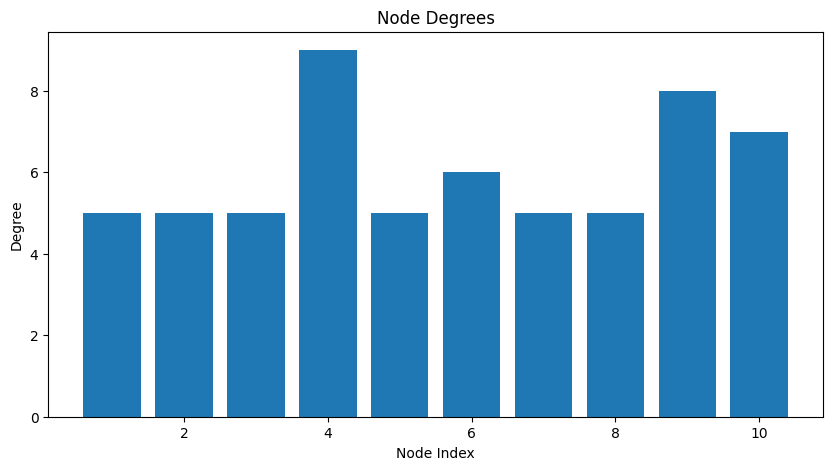

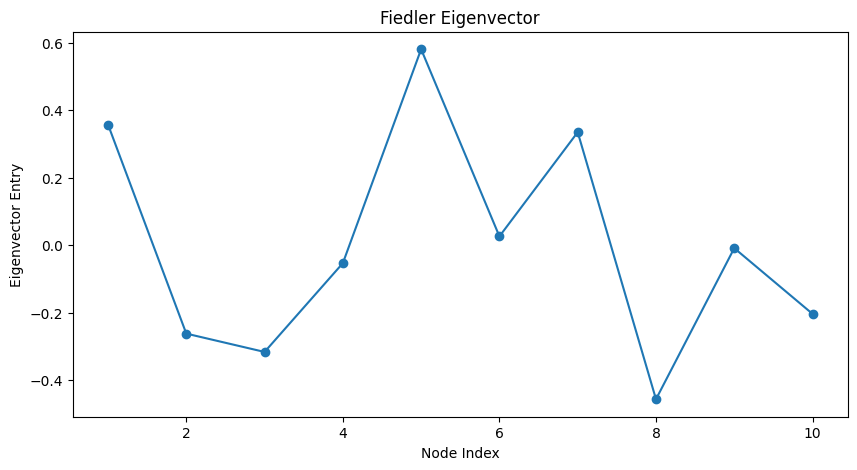

In [10]:
print("Analyzing network structure for geo-based graph:")
analyze_network(G_geo)

Analyzing network structure for statistics-based graph:


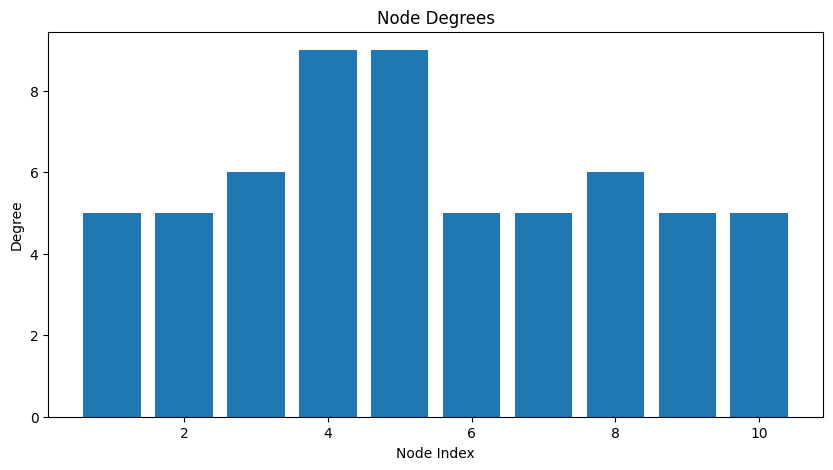

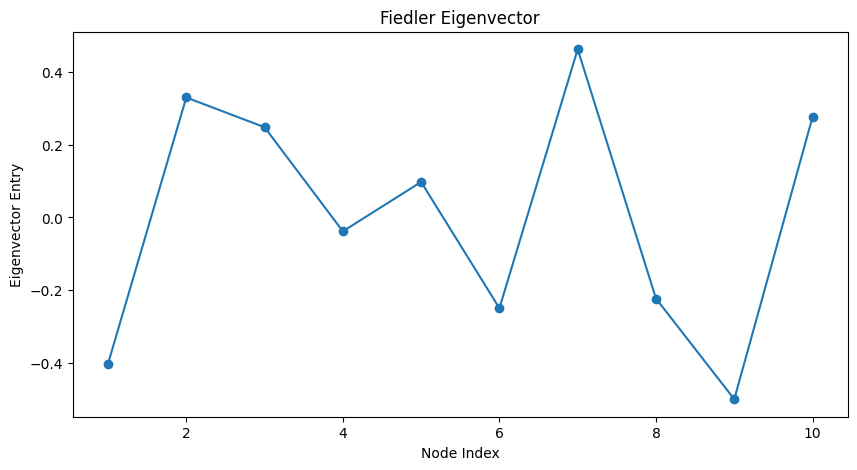

In [11]:
print("Analyzing network structure for statistics-based graph:")
analyze_network(G_stat)

## Local Averaging FL

<a id='local_averaging'></a>
<div class="alert alert-warning">

### 📌 TASK 2.4: Local Averaging for Federated Learning
Your task is to implement the function **`local_averaging(G)`**, which simulates a simple federated learning algorithm over a **FL network** that is provided as input`G` (`networkx.Graph`). This function will estimate node-level temperatures using local neighbor data and evaluate the **prediction error**.

For each node in the graph:
- **Predict the average temperature** by computing the mean temperature of its neighbors’ datasets.
- If a node **has no neighbors**, use its own dataset’s average as the prediction.
- **Compute the actual average temperature** for the node.
- **Calculate the prediction error** as the difference between the predicted and actual average temperatures.
- **Store the error** in a dictionary `prediction_errors` with the node index as the key.
- The function should return the dictionary `prediction_errors`.

Use `local_averaging()` to compute **prediction errors** for both:
  - **Geo-based network (`G_geo`)**
  - **Stat-based network (`G_stat`)**

###  Format the Results in a DataFrame
- Construct a Pandas DataFrame with the following columns:
  - `"Geo-Based Error"` → Prediction errors from `G_geo`
  - `"Stat-Based Error"` → Prediction errors from `G_stat`
- Print the DataFrame to display the results.

### Hints
- **Loop through all nodes** in the graph to calculate predicted and actual temperatures.  
- **Retrieve neighbors** using `G.neighbors(node)`.  
- **Compute predicted temperature**: If the node **has neighbors**, use the mean temperature of all neighbors' datasets. If the node **has no neighbors**, use the node’s own dataset mean.  
- **Compute the prediction error** `prediction_error = predicted_temperature - actual_temperature`

In [14]:
def local_averaging(G):
    """
    Implements a simple federated learning algorithm for a FL network represtend by the input `G` which is a `netwworkx.Graph()`object. 
    Each node predicts temperature by averaging the local datasets of its neighbors. Computes the actual average temperature for 
    each node. Computes and stores the prediction error for each node.

    Parameters:
    G (networkx.Graph): The FL network graph where each node has a 'dataset' attribute.

    Returns:
    dict: A dictionary where keys are node IDs and values are prediction errors.
    """
    
    # Initialize dictionary to store prediction errors
    prediction_errors = {}
    
    # Predict average and compute the prediction error
    # for i in G.nodes():
        # ...
        # ...
        # ...
    # return prediction_errors
    
    for node in G.nodes():
        # Get the local dataset for the node
        node_dataset = G.nodes[node]['dataset']
        
        # Calculate the actual average temperature for the node
        actual_avg_temperature = np.mean(node_dataset)
        
        # Getting the neighbors of the node
        neighbors = list(G.neighbors(node))
        
        # If the node has neighbors, predict the temperature based on the neighbors' datasets
        if neighbors:
            predicted_temperature = np.mean([np.mean(G.nodes[neighbor]['dataset']) for neighbor in neighbors])
        else:
            # If the node has no neighbors, using its own dataset's average as the prediction
            predicted_temperature = actual_avg_temperature
        
        # Calculate the prediction error
        prediction_error = predicted_temperature - actual_avg_temperature
        
        # Store the prediction error in the dictionary
        prediction_errors[node] = prediction_error
    
    return prediction_errors

# Compute prediction errors for both networks
prediction_errors_geo = local_averaging(G_geo)
prediction_errors_stat = local_averaging(G_stat)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame({
    "Geo-Based Error": list(prediction_errors_geo.values()),
    "Stat-Based Error": list(prediction_errors_stat.values())
}, index=list(G_geo.nodes()))

# Display the results
print(results_df)

   Geo-Based Error  Stat-Based Error
0        -7.107389         -1.694677
1         6.848141          3.706773
2         1.432471         -0.307620
3         0.966413          0.966413
4         2.637288         -0.904123
5       -12.469832         -8.533987
6        11.270813          2.063615
7        -6.606044          0.073781
8        -8.270796         -2.431390
9        12.844463          7.058151


In [15]:
# Sanity checks

# Ensure every node has a prediction error
assert len(local_averaging(G_geo)) == 10, "Prediction error missing for some nodes"
assert len(local_averaging(G_stat)) == 10, "Prediction error missing for some nodes"

print('Sanity check passed!')


Sanity check passed!
